We used the 2 estimated parameters to predict daily streamflows, in the case of $\psi_2(q,t)=x_tq_t$, where:
    \begin{equation}
    x_t =
    \begin{cases}
    x_{t-1} - \frac{\mu}{\lambda} x_{t-1}, & \text{if } q_t = 0 \\
    x_{t-1} + \frac{\mu}{\lambda} q_t, & \text{if } q_t > 0
    \end{cases}
    \end{equation}

We have the two scenarios: \\
1- Simulating daily streamflow solely from precipitation and potential evapotranspiration data.

2- Forecasting day-ahead streamflows, where observed streamflow at time
$t$ is used to predict streamflow at
($t+1$)

Additionally, we use different metrics to evaluate the model performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import random
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import levy_stable
import os

from google.colab import files
import matplotlib.dates as mdates

In [ ]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HINNs/savè.xlsx')

#Calibration data
discharge = daily.iloc[:1280, 0].to_numpy()
prec = daily.iloc[:1280, 1].to_numpy()
pet = daily.iloc[:1280, 2].to_numpy()

In [ ]:
# Performance metrics

def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2

def calculate_mae(observed, predicted):
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_ca(rmse, mae, r2):
    ca = 0.33 * (rmse + mae + (1 - r2))
    return ca


SIMULATION

In [ ]:
#Compute the Effective precipitation
prec_eff = prec - pet
prec_eff[prec_eff < 0] = 0

#State of the basin X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]   #This could be adjusted for improving the calibration
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [ ]:
#parameters
mu = 0.87897025
lambd =  3.58509738


#Basin state
X = state_basin(mu, lambd, prec_eff)

#EQUATION
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]

for k in range(1, len(discharge)):
    if Qsim[k-1] < 0:
        Qsim[k-1] = 0
    Qsim[k] = Qsim[k-1] - (mu/lambd) * Qsim[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff[k-1]


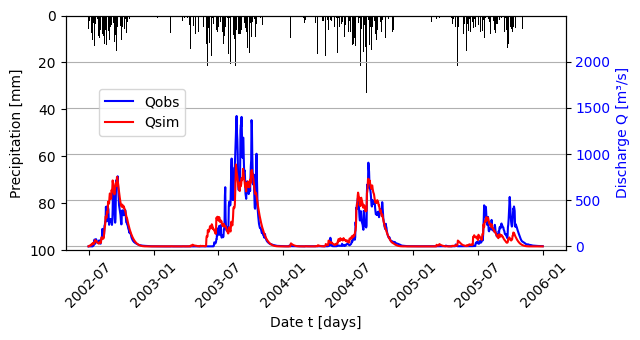

In [ ]:
#PLOT

# Create a range of dates from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2002-07-01')
time2 = np.datetime64('2005-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec, color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a secondary y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot the simulated discharge
ax2.plot(time, Qsim, 'red', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-40, 2500)
ax2.set_yticks(np.arange(0, 2500, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
plt.grid(True)


# Use tight_layout to avoid overlaps
plt.tight_layout()


# Show the plot
plt.show()


In [ ]:
# Model Performance
nse_value = nash_sutcliffe_efficiency(discharge, Qsim)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge, Qsim)
print('rmse=', rmse)

r2 = calculate_r2(discharge, Qsim)
print('r2=', r2)

mae = calculate_mae(discharge, Qsim)
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.7924316952480134
rmse= 107.39337350021172
r2= 0.7925266432460102
mae= 53.134437829201445
CA= 53.04264394643516


VALIDATION

In [ ]:
# Validation data
discharge1 = daily.iloc[1280:, 0].to_numpy()
prec1 = daily.iloc[1280:, 1].to_numpy()
pet1 = daily.iloc[1280:, 2].to_numpy()

In [ ]:
#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

In [ ]:
#Basin state
X = state_basin(mu, lambd, prec_eff1)

#EQUATION
Qsim1 = np.zeros(len(discharge1))
Qsim1[0] = discharge1[0]

for k in range(1, len(discharge1)):
    if Qsim1[k-1] < 0:
       Qsim1[k-1] = 0
    Qsim1[k] = Qsim1[k-1] - (mu/lambd) * Qsim1[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff1[k-1]


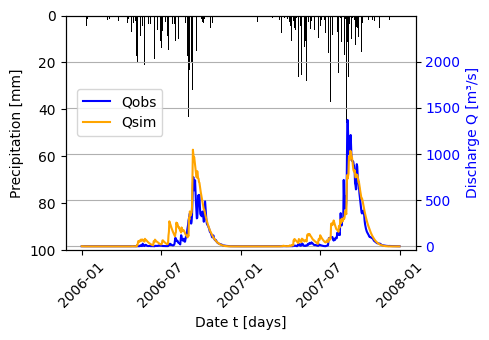

In [ ]:
#PLOT

time1 = np.datetime64('2006-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a specified size
fig, ax1 = plt.subplots(figsize=(5., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Use MonthLocator to set ticks every 6 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # January 1st, July 1st

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a secondary y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1, 'b', label='Qobs')

# Plot the prediction
ax2.plot(time, Qsim1, 'orange', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-40, 2500)
ax2.set_yticks(np.arange(0, 2500, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
plt.grid(True)

# Use tight_layout to avoid overlaps
plt.tight_layout()


# Show the plot
plt.show()


In [ ]:
# Model performance
nse_value = nash_sutcliffe_efficiency(discharge1, Qsim1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qsim1)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qsim1)
print('r2=', r2)

mae = calculate_mae(discharge1, Qsim1)
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.8362315373451079
rmse= 86.15550453578295
r2= 0.8647366202794174
mae= 44.28507297422546
CA= 43.09002749361057


DAY-AHEAD LEAD TIME PREDICTION

In [ ]:
#EQUATION
Qsim1 = np.zeros(len(discharge1))
Qsim1[0] = discharge1[0]

for k in range(1, len(discharge1)):

    Qsim1[k] = discharge1[k-1] - (mu/lambd) * discharge1[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff1[k-1]


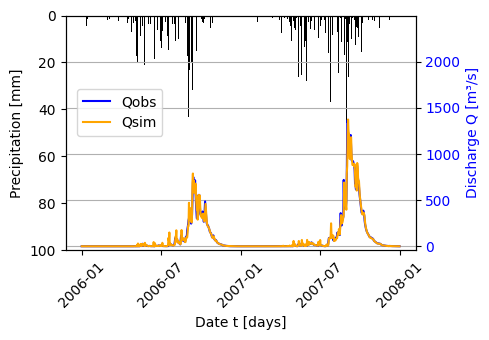

In [ ]:
#PLOT

time1 = np.datetime64('2006-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a specified size
fig, ax1 = plt.subplots(figsize=(5., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Use MonthLocator to set ticks every 6 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # January 1st, July 1st

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a secondary y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1, 'b', label='Qobs')

# Plot the prediction
ax2.plot(time, Qsim1, 'orange', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-40, 2500)
ax2.set_yticks(np.arange(0, 2500, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
plt.grid(True)

# Use tight_layout to avoid overlaps
plt.tight_layout()


# Show the plot
plt.show()


In [ ]:
#Model Performance
nse_value = nash_sutcliffe_efficiency(discharge1, Qsim1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qsim1)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qsim1)
print('r2=', r2)

mae = calculate_mae(discharge1, Qsim1)
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.9675513429975432
rmse= 38.350078507009556
r2= 0.9681278515163142
mae= 13.367395956206483
CA= 17.07728438186091
